In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_excel('311_Service_Requests_20251022.xls')
print(df)

           SR_NUMBER                      SR_TYPE SR_SHORT_CODE  \
0      SR25-01948318     Aircraft Noise Complaint           AVN   
1      SR25-01948317   Street Light Out Complaint           SFD   
2      SR25-01948316     Aircraft Noise Complaint           AVN   
3      SR25-01948315    311 INFORMATION ONLY CALL        311IOC   
4      SR25-01948314     Aircraft Noise Complaint           AVN   
...              ...                          ...           ...   
65530  SR25-01869126  Pothole in Street Complaint           PHF   
65531  SR25-01869125    311 INFORMATION ONLY CALL        311IOC   
65532  SR25-01869124    311 INFORMATION ONLY CALL        311IOC   
65533  SR25-01869122    311 INFORMATION ONLY CALL        311IOC   
65534  SR25-01869121     Aircraft Noise Complaint           AVN   

                        CREATED_DEPARTMENT  \
0                                      NaN   
1      CDOT - Department of Transportation   
2                                      NaN   
3          


Top Features Predicting Time to Close:
SR_SHORT_CODE          0.362236
SR_TYPE                0.252654
CREATED_DAY_OF_WEEK    0.070090
CREATED_HOUR           0.060024
WARD                   0.053252
COMMUNITY_AREA         0.045222
ZIP_CODE               0.043670
POLICE_DISTRICT        0.029156
ORIGIN                 0.028217
ELECTRICAL_DISTRICT    0.022507
dtype: float64


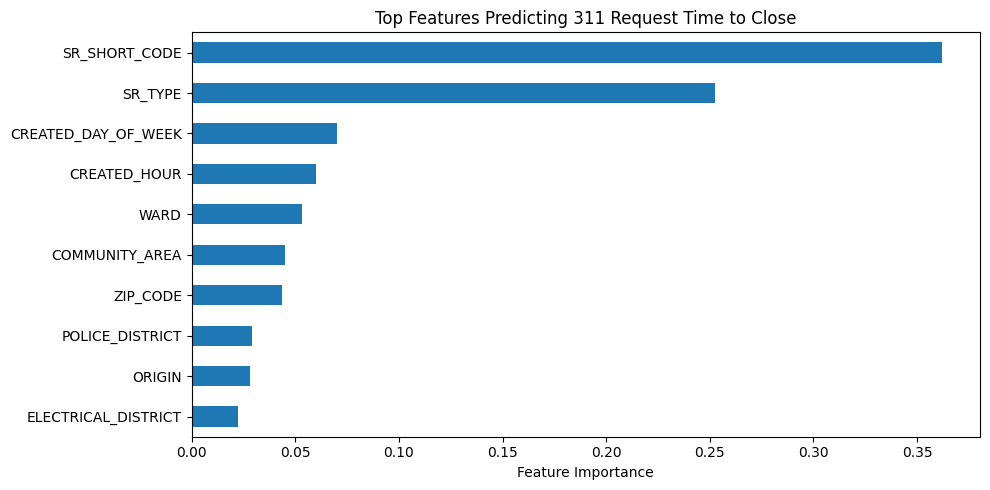

In [4]:

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Clean and process date/time columns
for col in ["CREATED_DATE", "CLOSED_DATE"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Compute time to close
df["TIME_TO_CLOSE_HOURS"] = (df["CLOSED_DATE"] - df["CREATED_DATE"]).dt.total_seconds() / 3600

# Remove rows without a closed date
df = df.dropna(subset=["TIME_TO_CLOSE_HOURS"])

feature_cols = [
    "SR_TYPE",
    "SR_SHORT_CODE",
    "CREATED_DEPARTMENT",
    "OWNER_DEPARTMENT",
    "STATUS",
    "ORIGIN",
    "CITY",
    "STATE",
    "ZIP_CODE",
    "COMMUNITY_AREA",
    "WARD",
    "ELECTRICAL_DISTRICT",
    "POLICE_DISTRICT",
    "CREATED_HOUR",
    "CREATED_DAY_OF_WEEK",
    "CREATED_MONTH",
]

X = df[feature_cols].copy()
y = df["TIME_TO_CLOSE_HOURS"]


for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].fillna("Unknown")
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# get feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nTop Features Predicting Time to Close:")
print(importances.head(10))


plt.figure(figsize=(10, 5))
importances.head(10).plot(kind="barh")
plt.title("Top Features Predicting 311 Request Time to Close")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate model performance
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Model Performance:")
print(f"MAE  (Mean Absolute Error): {mae:.2f} hours")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} hours")
print(f"R²   (Explained Variance): {r2:.3f}")


 Model Performance:
MAE  (Mean Absolute Error): 4.67 hours
RMSE (Root Mean Squared Error): 16.62 hours
R²   (Explained Variance): 0.689
